# สมาชิกผู้จัดทำ

สิทธิเจตน์ วงศ์ทิชาวัฒน์ 6210503853

นทวัจน์ เมี้ยนละม้าย 6210503624

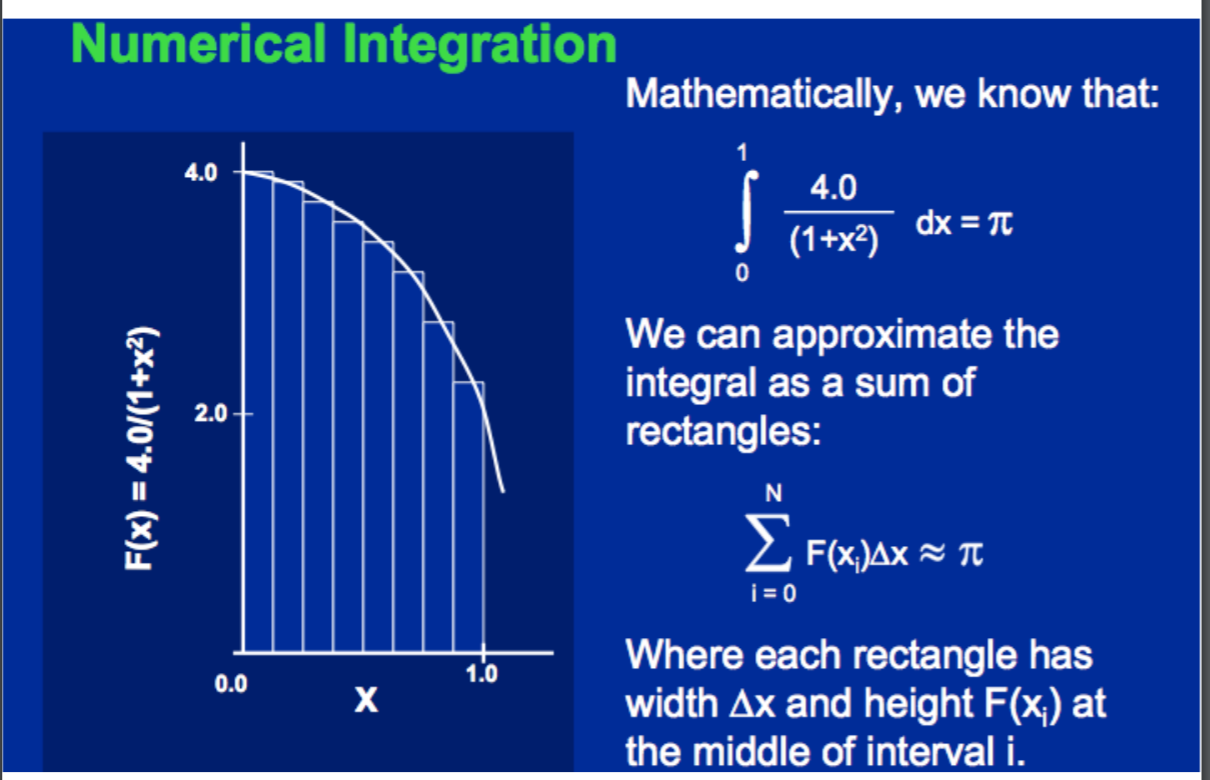

Consider the sequential version.

In [ ]:
%%file pi.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>


#define NSIZE 200000000
#define NTHREADS 5

static long num_steps = 100000;
double step;

void main () {
  int i;
  double x, pi, sum = 0.0;
  step = 1.0/(double)num_steps;

  double t1 = omp_get_wtime();

  for (i = 1; i <= num_steps; i++) {
    x = (i - 0.5) * step;
    sum = sum + 4.0 / (1.0 + x*x);
  }

  pi = sum / num_steps;
  double t2 = omp_get_wtime();
  printf ("pi = %6.12f\n", pi);
  printf ("Compute time = %6.12f seconds\n", t2-t1);

}


Overwriting pi.c


In [ ]:
%%script bash
gcc pi.c -o pi -fopenmp
./pi

pi = 3.141592653598
Compute time = 0.001640688000 seconds


#   Distribute work 1

convert the code into openMP.
1. Distribute the total interations into omp threads.
use "omp parallel"


2. The master thread performa the last division step.

Assume 5 threads are executing.

In [ ]:
%%file pi2.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
#define NUM_THREADS 5
static long num_steps = 100000;
double step;
void main () {
  int i, thread_id, task_size; double x, pi;
  double sum = 0.0;
  step = 1.0/(double) num_steps;
 
  omp_set_num_threads(NUM_THREADS);
  task_size = (int) (num_steps / NUM_THREADS);
  
  // loop with omp parallel
  double t1 = omp_get_wtime();
  #pragma omp parallel private(thread_id, i, x)
  {
      thread_id = omp_get_thread_num();
      for (i = thread_id*task_size+1; i <= thread_id*task_size+task_size; i++) {
        x = (i - 0.5) * step;
        #pragma omp critical
        {
            sum += 4.0 / (1.0 + x*x);
        }
      }
  }
  
  

  // master thread perform the division
  thread_id = omp_get_thread_num();
  printf("thread_id = %d\n", thread_id);
  pi = sum/ num_steps;
  double t2 = omp_get_wtime();
  printf ("pi = %6.12f\n", pi);
  printf ("Compute time = %6.12f seconds\n", t2-t1);
}


Overwriting pi2.c


In [ ]:
%%script bash
gcc pi2.c -o pi2 -fopenmp
./pi2

thread_id = 0
pi = 3.141592653598
Compute time = 0.002275858000 seconds


# Distribute work 2
convert the code into openMP.

Use "omp parallel for" 
in such a way that each thread work on each portion equally. Each thread has its own sum.
The master thread sums the sum values from other threads and perform the last division step.

In [ ]:
%%file pi3.c
#include <stdio.h>
#include <stdlib.h>
 
#include <omp.h>
#define NUM_THREADS 5
static long num_steps = 100000; 
double step;
void main () {
  double x, pi;
  double sum_shared = 0.0, sum_local = 0.0; // declare sum
  step = 1.0/(double) num_steps;
  omp_set_num_threads(NUM_THREADS);
 

  double t1 = omp_get_wtime();
  #pragma omp parallel for schedule(static,num_steps/NUM_THREADS) private(x)
  
  for (int i = 1; i <= num_steps; i++) {
    x = (i - 0.5) * step;
    #pragma omp atomic
    sum_local += 4.0 / (1.0 + x*x);
  }

  

  // accumlate sum  

  // master performs the last division
  int thread_id;
  thread_id = omp_get_thread_num();
  printf("thread_id = %d\n", thread_id);
  sum_shared += sum_local;
  pi = sum_shared/ num_steps;
  double t2 = omp_get_wtime();
  printf ("pi = %6.12f\n", pi);
  printf ("Compute time = %6.12f seconds\n", t2-t1);
}

Overwriting pi3.c


In [ ]:
%%script bash
gcc pi3.c -o pi3 -fopenmp
./pi3

thread_id = 0
pi = 3.141592653598
Compute time = 0.002408957000 seconds


Modify the above code by using 
omp parallel for


In [ ]:
%%file pi5.c
#include <stdio.h>
#include <stdlib.h>
 
#include <omp.h>
#define NUM_THREADS 5
static long num_steps = 100000; 
double step;
void main () {
   double x, pi ;
   double sum_shared = 0.0 ; // your sum
  step = 1.0/(double) num_steps;
  omp_set_num_threads(NUM_THREADS);
  
 
  // sum initialization
   double sum_local = 0.0;

  double t1 = omp_get_wtime();
  // pragma parallel for here
  #pragma omp parallel for private(x)
  for (int i = 1; i <= num_steps; i++) {
    x = (i - 0.5) * step;
    #pragma omp atomic
    sum_local += 4.0 / (1.0 + x*x);
  }


  int thread_id;
  thread_id = omp_get_thread_num();
  printf("thread_id = %d\n", thread_id);
  sum_shared += sum_local;
  pi = sum_shared / num_steps;
  double t2 = omp_get_wtime();
  printf ("pi = %6.12f\n", pi);
  printf ("Compute time = %6.12f seconds\n", t2-t1);
}

Overwriting pi5.c


In [ ]:
%%script bash
gcc pi5.c -o pi5 -fopenmp
./pi5

thread_id = 0
pi = 3.141592653598
Compute time = 0.002245019000 seconds


# Distributed version 3

Use "omp parallel" for and "reduction" into "sum" variable on the master.

In [ ]:
%%file pi4.c
#include <stdio.h>
#include <stdlib.h>
 
#include <omp.h>
#define NUM_THREADS 5
static long num_steps = 100000; double step;

 
void main ()
{  
  double x, pi ;
  double sum_shared = 0.0 ;
  step = 1.0/(double) num_steps;
  omp_set_num_threads(NUM_THREADS);
  
  double t1 = omp_get_wtime();
  #pragma omp parallel for reduction(+:sum_shared) private(x)
  for (int i = 1; i <= num_steps; i++) {
    x = (i - 0.5) * step;
    sum_shared += 4.0 / (1.0 + x*x);
  }

  int thread_id;
  thread_id = omp_get_thread_num();
  printf("thread_id = %d\n", thread_id);
  pi = sum_shared / num_steps;
  double t2 = omp_get_wtime();
  printf ("pi = %6.12f\n", pi);
  printf ("Compute time = %6.12f seconds\n", t2-t1);
}

Overwriting pi4.c


In [ ]:
%%script bash
gcc pi4.c -o pi4 -fopenmp
./pi4

thread_id = 0
pi = 3.141592653598
Compute time = 0.001348743000 seconds


เปรียบเทียบเวลาการทำงานของทั้ง 5 รูปแบบ

|             | time (s) |
| ----------- | ----------- |
| seqeuntial      | 0.001640688000         |
| omp parallel   | 0.002275858000        |
| omp parallel for schedule | 0.002408957000 |
| omp parallel for  | 0.002245019000  |
| omp parallel for reduction | 0.001348743000  |

จะเห็นได้ว่าการใช้ openMP parallel แบบ reduction จะทำงานได้เร็วกว่าการทำงานแบบ seqeuntial แต่ในการใช้ openMP แบบ parallel และ parallel for จะทำงานได้ช้ากว่า sequential